In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

/usr/lib64/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "
2024-07-13 10:50:03.094078: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-13 10:50:03.104993: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-13 10:50:03.189817: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-13 10:50:04.112190: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find Tensor

In [2]:
import os
output_folder = '/home/genty/Hiwi-TimeSeries/Hiwi-TimeSeries/output/'

## 8 Datasets

In [3]:
file_path = ['/home/genty/Hiwi-TimeSeries/Hiwi-TimeSeries/dataset/DMC60H/AL2007_Bauteil_1/I40_Alu_Tr_Mat_1_alldata_allforces_MRR_allcurrent.csv',
             '/home/genty/Hiwi-TimeSeries/Hiwi-TimeSeries/dataset/DMC60H/AL2007_Bauteil_1_Aircut/I40_Alu_Tr_Air_1_alldata_allcurrent.csv',
             '/home/genty/Hiwi-TimeSeries/Hiwi-TimeSeries/dataset/DMC60H/AL2007_Bauteil_2/I40_Alu_Val_Mat_1_alldata_allforces_MRR_allcurrent.csv',
             '/home/genty/Hiwi-TimeSeries/Hiwi-TimeSeries/dataset/DMC60H/AL2007_Bauteil_2_Aircut/I40_Alu_Val_Air_1_alldata_allcurrent.csv',
             '/home/genty/Hiwi-TimeSeries/Hiwi-TimeSeries/dataset/DMC60H/S235JR_Bauteil_1/I40_St_Tr_Mat_1_alldata_allforces_MRR_allcurrent.csv',
             '/home/genty/Hiwi-TimeSeries/Hiwi-TimeSeries/dataset/DMC60H/S235JR_Bauteil_1_Aircut/I40_St_Tr_Air_1_alldata_allcurrent.csv',
             '/home/genty/Hiwi-TimeSeries/Hiwi-TimeSeries/dataset/DMC60H/S235JR_Bauteil_2/I40_St_Val_Mat_1_alldata_allforces_MRR_allcurrent.csv',
             '/home/genty/Hiwi-TimeSeries/Hiwi-TimeSeries/dataset/DMC60H/S235JR_Bauteil_2_Aircut/I40_St_Val_Air_1_alldata_allcurrent.csv']

In [4]:
features = ['a_x', 'a_y', 'a_z', 'a_sp', 'v_x', 'v_y', 'v_z', 'v_sp', 'pos_x', 'pos_y', 'pos_z', 'pos_sp', 'curr_sp']
result_df = pd.DataFrame(columns=['Dataset', 'Train_R2', 'Train_RMSE', 'Test_R2', 'Test_RMSE'])

In [5]:
def create_dataset(X, y, time_step=60):
    Xs, ys = [], []
    for i in range(len(X) - time_step):
        Xs.append(X[i:(i + time_step)])
        ys.append(y[i + time_step])
    return np.array(Xs), np.array(ys)

In [6]:
def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

In [9]:
#for file in file_path:
file=file_path[3]
df = pd.read_csv(file)
df =df[features]
X = df.drop(columns=['curr_sp'])
y = df[['curr_sp']].abs()
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))
scaled_X = scaler_X.fit_transform(X)
scaled_y = scaler_y.fit_transform(y)

train_size = int(len(scaled_X) * 0.5)
test_size = len(scaled_X) - train_size
X_train, X_test = scaled_X[:train_size], scaled_X[train_size:]
y_train, y_test = scaled_y[:train_size], scaled_y[train_size:]

time_step = 60
X_train, y_train = create_dataset(X_train, y_train, time_step)
X_test, y_test = create_dataset(X_test, y_test, time_step)

input_shape = (X_train.shape[1], X_train.shape[2])
model = build_model(input_shape)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Make Predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Inverse transform predictions
train_predict_inv = scaler_y.inverse_transform(train_predict)
y_train_inv = scaler_y.inverse_transform(y_train)
test_predict_inv = scaler_y.inverse_transform(test_predict)
y_test_inv = scaler_y.inverse_transform(y_test)

train_df = pd.DataFrame({
        'Train_y': y_train_inv.flatten(),
        'Train_pred_y': train_predict_inv.flatten()
    })

filename = os.path.join(output_folder, f'trains_{os.path.basename(file)}.csv')
train_df.to_csv(filename, index=False)
test_df = pd.DataFrame({
        'Test_y': y_test_inv.flatten(),
        'Test_pred_y': test_predict_inv.flatten()
    })

filename = os.path.join(output_folder, f'tests_{os.path.basename(file)}.csv')
test_df.to_csv(filename, index=False)

# Calculate R2 and RMSE
train_r2 = r2_score(y_train_inv, train_predict_inv)
test_r2 = r2_score(y_test_inv, test_predict_inv)
train_rmse = np.sqrt(mean_squared_error(y_train_inv, train_predict_inv))
test_rmse = np.sqrt(mean_squared_error(y_test_inv, test_predict_inv))

# Append the results to the dataframe
result_df = result_df.append({
    'Dataset': os.path.basename(file),
    'Train_R2': train_r2,
    'Train_RMSE': train_rmse,
    'Test_R2': test_r2,
    'Test_RMSE': test_rmse
}, ignore_index=True)

Epoch 1/50


/home/genty/.local/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


298/298 ━━━━━━━━━━━━━━━━━━━━ 19s 58ms/step - loss: 0.0040 - val_loss: 0.0031
Epoch 2/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 16s 55ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 3/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 16s 53ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 4/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 15s 50ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 5/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 17s 55ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 6/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 17s 56ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 7/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 17s 56ms/step - loss: 0.0029 - val_loss: 0.0022
Epoch 8/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 9/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 16s 55ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 10/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 17s 56ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 11/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 17s 56ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 12/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 

In [11]:
result_df

,Dataset,Train_R2,Train_RMSE,Test_R2,Test_RMSE
0,I40_Alu_Tr_Mat_1_alldata_allforces_MRR_allcurr...,0.534585,1.026919,0.427686,1.408146


In [ ]:
filename = os.path.join(output_folder, f'result_8datasets.csv')
result_df.to_csv(filename, index=False)


Dataset	Train_R2	Train_RMSE	Test_R2	Test_RMSE
0	I40_Alu_Tr_Mat_1_alldata_allforces_MRR_allcurr...	-0.008915	1.511971	-0.000352	1.861687
1	I40_Alu_Tr_Air_1_alldata_allcurrent.csv	0.472026	0.940386	0.402275	1.314347
2	I40_Alu_Val_Mat_1_alldata_allforces_MRR_allcur...	0.632989	1.464673	0.408071	2.209149
3	I40_Alu_Val_Air_1_alldata_allcurrent.csv	0.837309	0.946432	0.832433	1.041295
4	I40_St_Tr_Mat_1_alldata_allforces_MRR_allcurre...	0.808679	1.372259	0.710782	1.745845
5	I40_St_Tr_Air_1_alldata_allcurrent.csv	0.685055	0.979759	0.660211	1.372979
6	I40_St_Val_Mat_1_alldata_allforces_MRR_allcurr...	0.523850	1.699703	0.521837	1.860969
7	I40_St_Val_Air_1_alldata_allcurrent.csv	0.804612	0.942980	0.778690	1.091298

#### Plots

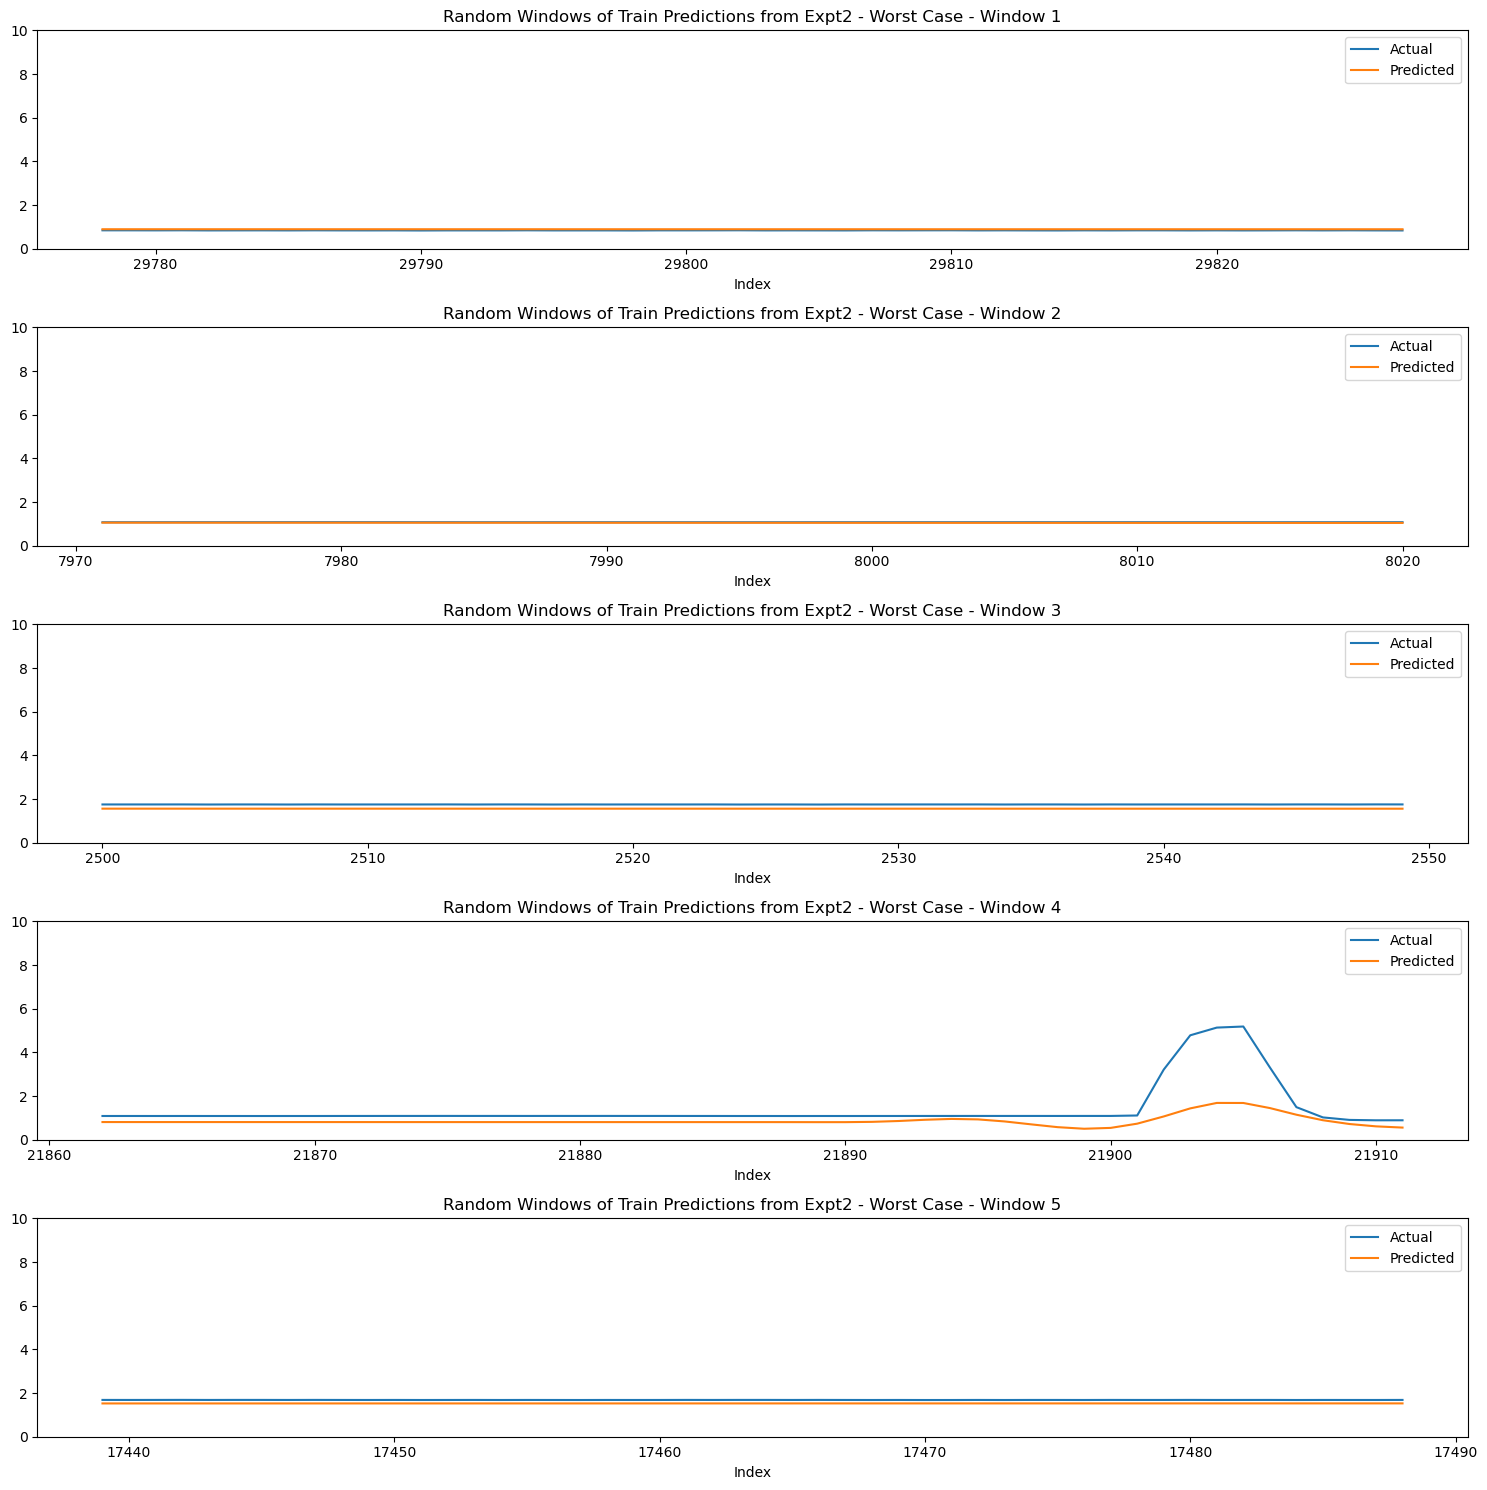

In [23]:
import random

def plot_random_windows(df, title, window_size=50, num_windows=5):
    fig, axes = plt.subplots(num_windows, 1, figsize=(15, 3*num_windows), sharey=True)
    
    if num_windows == 1:
        axes = [axes]
        
    overall_min = df.iloc[:, 0].min()  # Minimum value of column 1 across the entire DataFrame
    overall_max = df.iloc[:, 0].max()  # Maximum value of column 1 across the entire DataFrame
    
    for i in range(num_windows):
        if len(df) <= window_size:
            start = 0
            end = len(df)
        else:
            start = random.randint(0, len(df) - window_size)
            end = start + window_size

        axes[i].plot(df.iloc[start:end, 0], label='Actual')
        axes[i].plot(df.iloc[start:end, 1], label='Predicted')
        axes[i].set_xlabel('Index')
        axes[i].set_title(f'{title} - Window {i+1}')
        axes[i].legend()

    for ax in axes:
        ax.set_ylim(overall_min, 10)

    plt.tight_layout()
    plt.show()

df = pd.read_csv('/home/genty/Hiwi-TimeSeries/Hiwi-TimeSeries/output/trains_I40_Alu_Tr_Air_1_alldata_allcurrent.csv.csv')
title = f"Random Windows of Train Predictions from Expt2 - Worst Case"
plot_random_windows(df, title, window_size=50, num_windows=5)

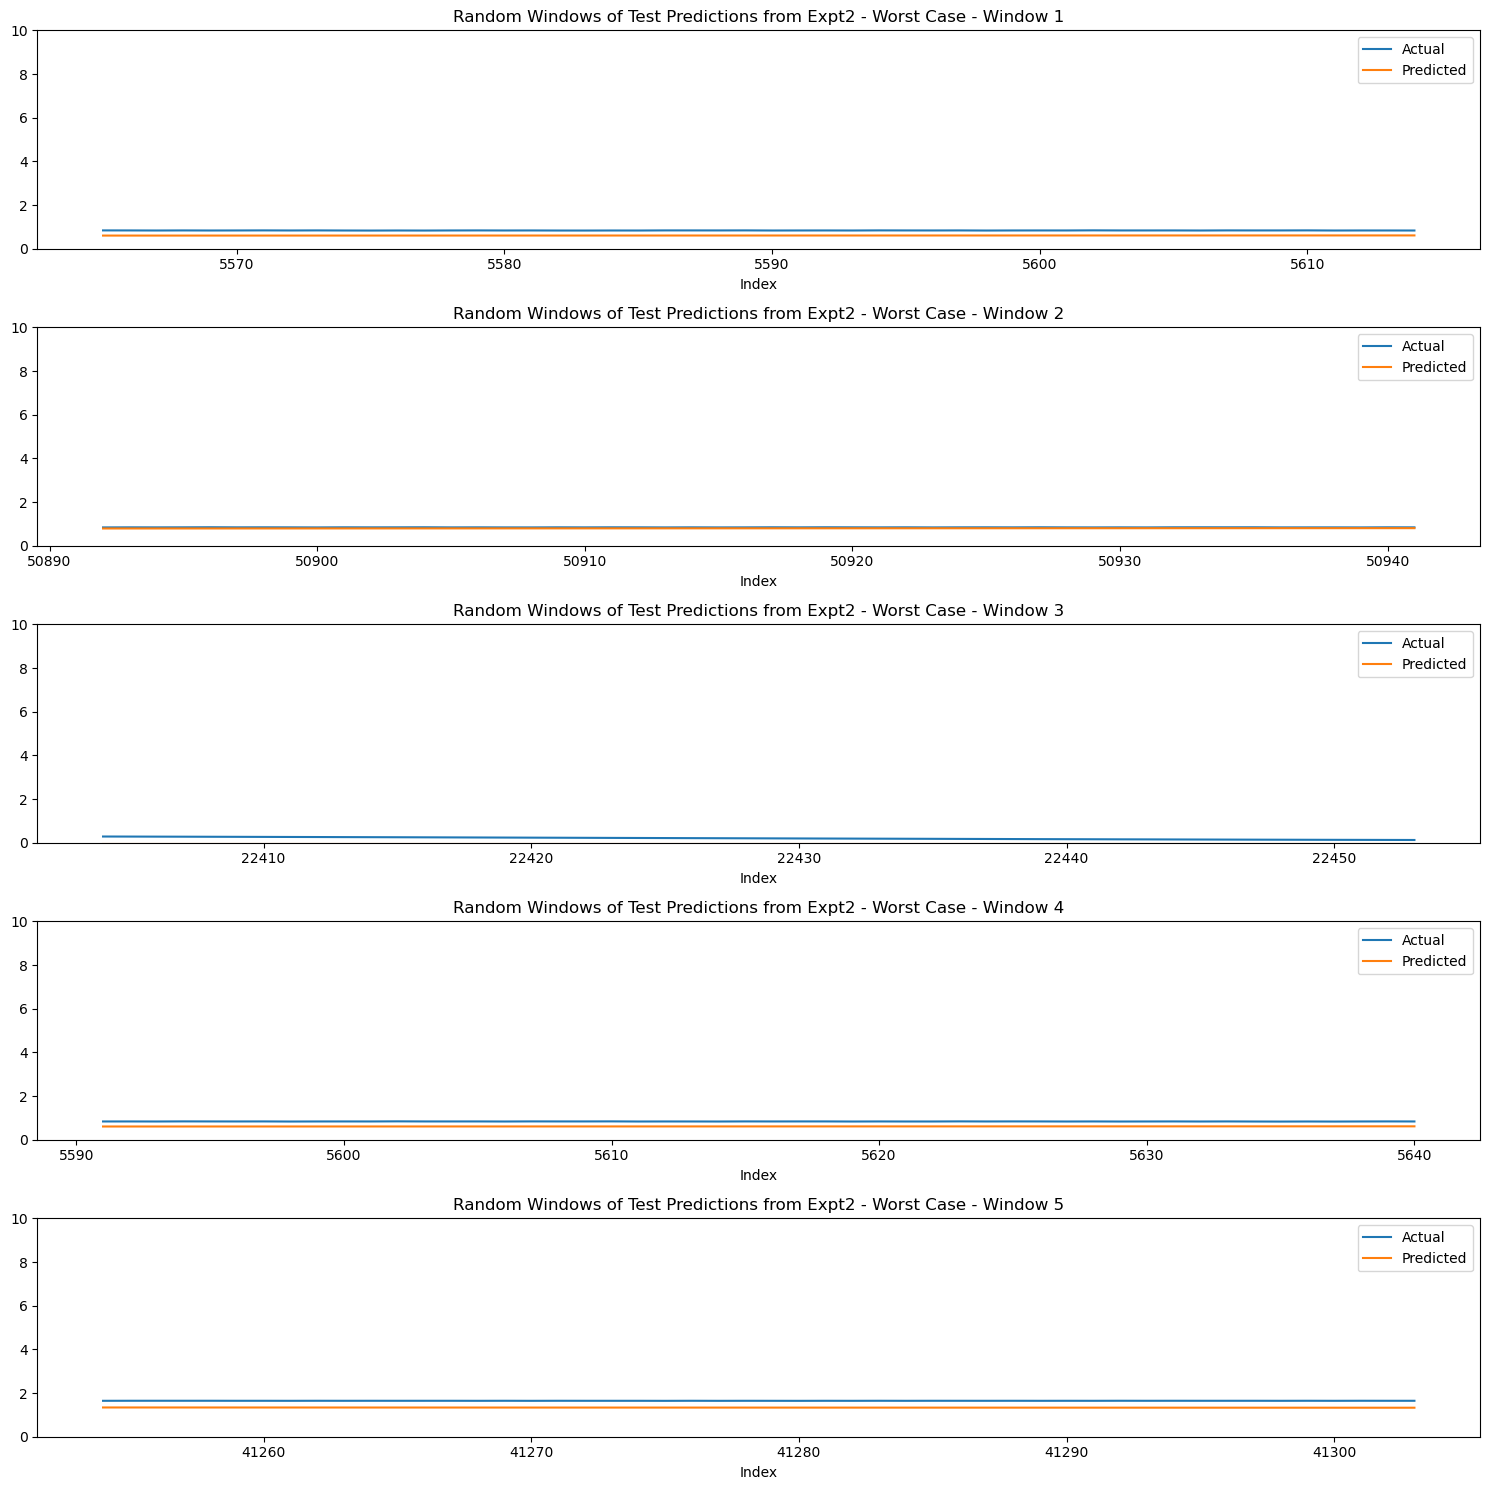

In [24]:

df = pd.read_csv('/home/genty/Hiwi-TimeSeries/Hiwi-TimeSeries/output/tests_I40_Alu_Tr_Air_1_alldata_allcurrent.csv.csv')
title = f"Random Windows of Test Predictions from Expt2 - Worst Case"
plot_random_windows(df, title, window_size=50, num_windows=5)

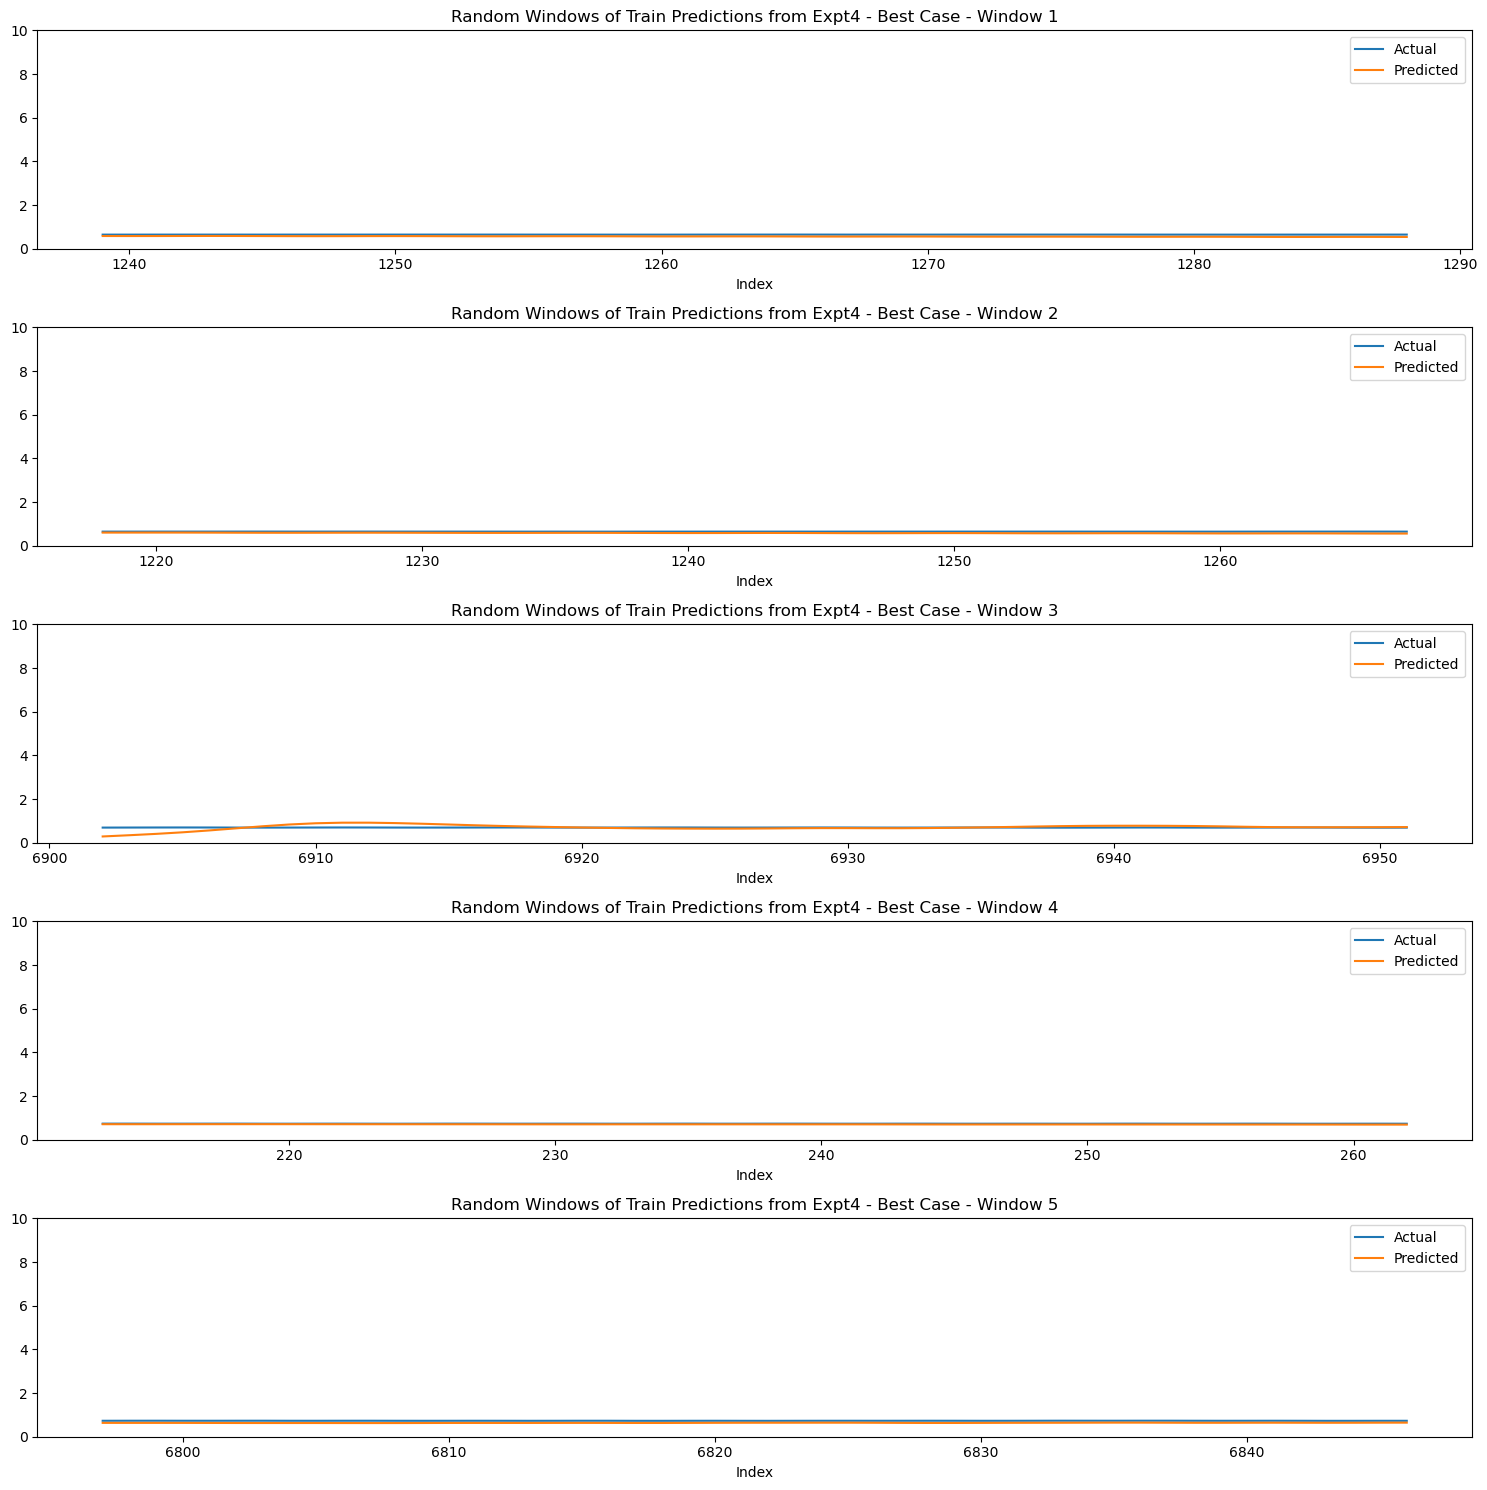

In [25]:
df = pd.read_csv('/home/genty/Hiwi-TimeSeries/Hiwi-TimeSeries/output/trains_I40_Alu_Val_Air_1_alldata_allcurrent.csv.csv')
title = f"Random Windows of Train Predictions from Expt4 - Best Case"
plot_random_windows(df, title, window_size=50, num_windows=5)

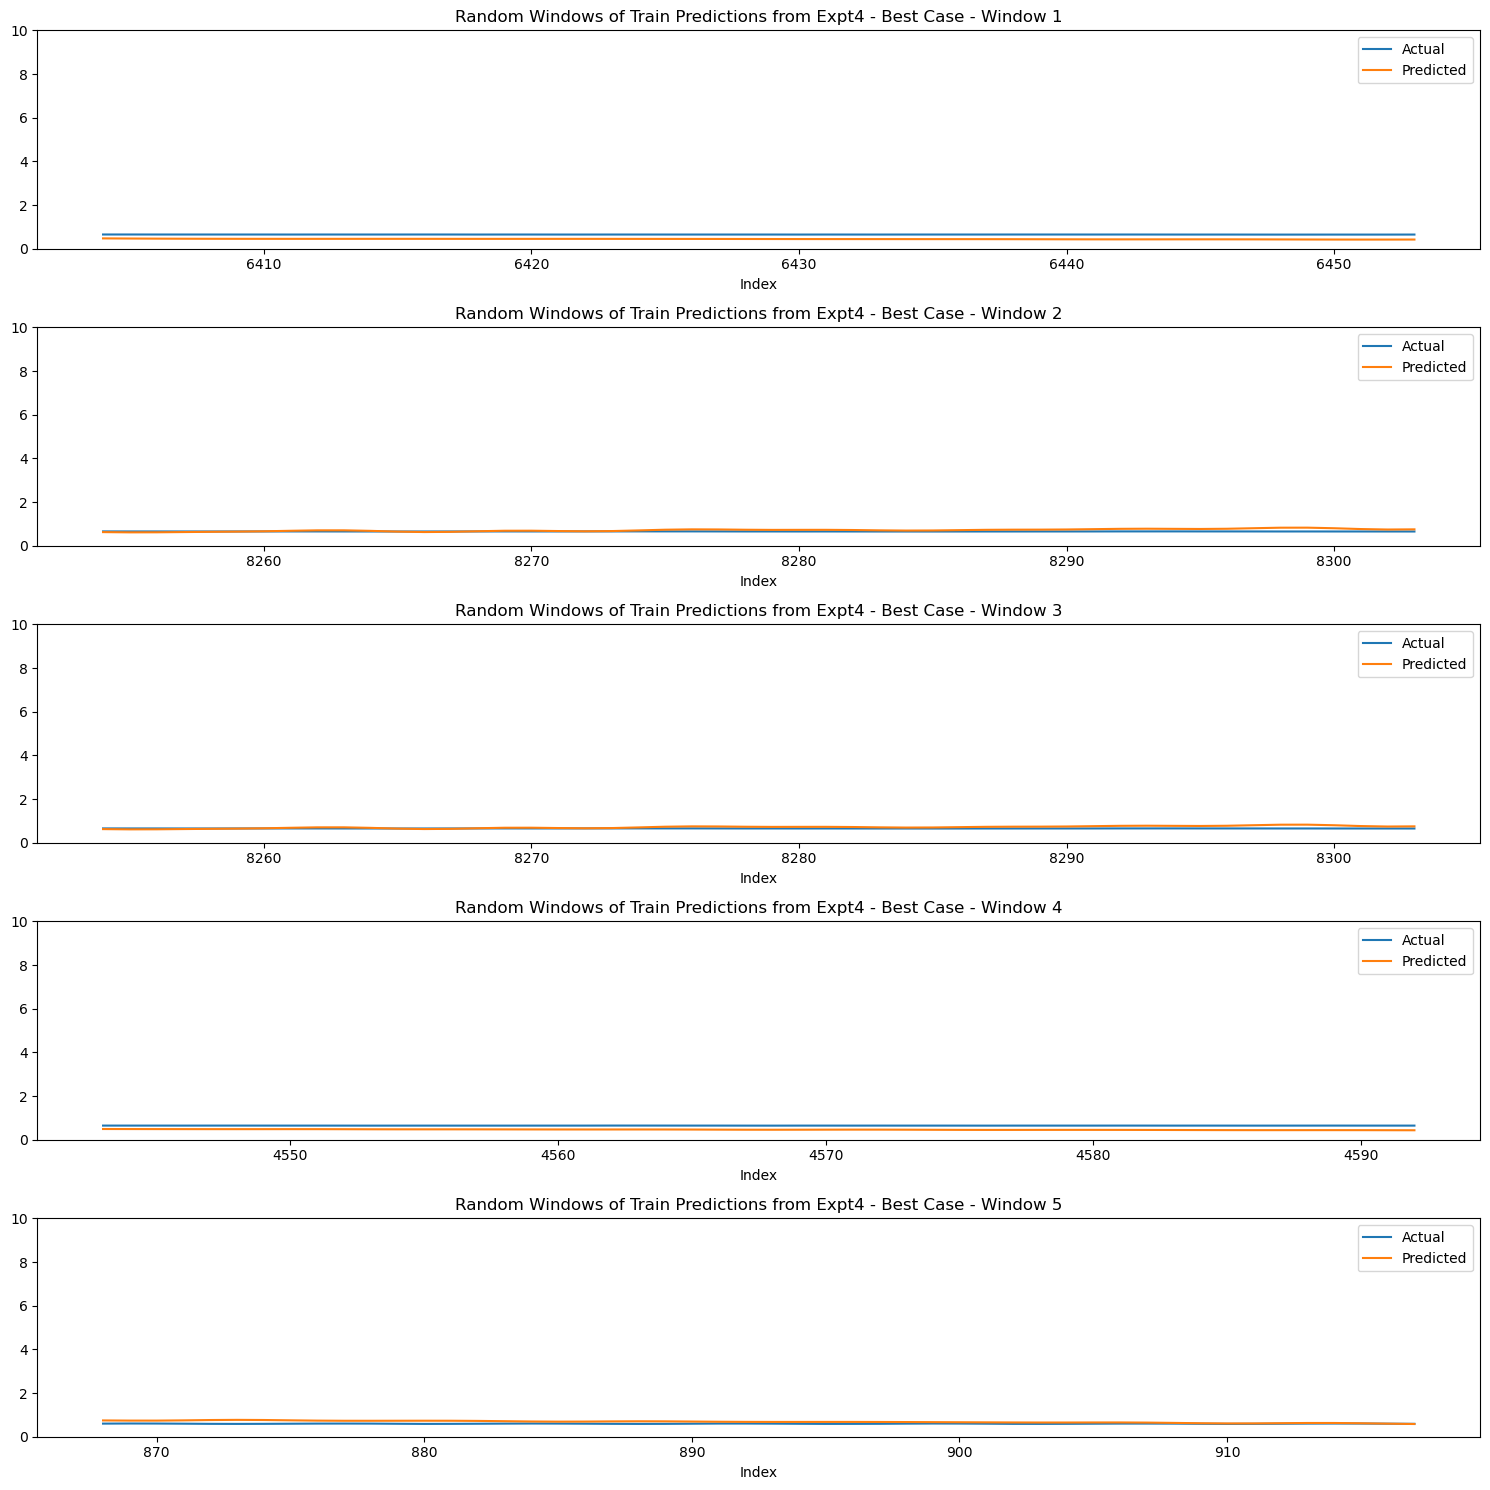

In [26]:
df = pd.read_csv('/home/genty/Hiwi-TimeSeries/Hiwi-TimeSeries/output/tests_I40_Alu_Val_Air_1_alldata_allcurrent.csv.csv')
title = f"Random Windows of Train Predictions from Expt4 - Best Case"
plot_random_windows(df, title, window_size=50, num_windows=5)

## New Dataset

In [2]:
file_path = '/home/genty/Hiwi-TimeSeries/Hiwi-TimeSeries/dataset/new_datasets/dataset1/RS_Energie_V_AL_2007.csv'
data = pd.read_csv(file_path)

In [3]:
data.head()

,CYCLE,CTRL_DIFF2|1,CTRL_DIFF2|2,CTRL_DIFF2|3,CTRL_DIFF2|4,CTRL_DIFF2|5,CTRL_DIFF2|6,TORQUE|1,TORQUE|2,TORQUE|3,...,ENC_POS|3,ENC_POS|4,ENC_POS|5,ENC_POS|6,LOAD|1,LOAD|2,LOAD|3,LOAD|4,LOAD|5,LOAD|6
0,7795223,-0.00001,-0.000023,-0.000006,NaN,NaN,0.044636,-0.098335,-0.501040,5.806445,...,-8.399994,NaN,NaN,90.094004,0.396729,2.087402,23.565674,NaN,NaN,0.0
1,7795224,0.00000,-0.000013,-0.000016,NaN,NaN,0.044636,-0.098335,-0.515088,5.808787,...,-8.399984,NaN,NaN,90.094004,0.402832,2.044678,23.529053,NaN,NaN,0.0
2,7795225,0.00001,-0.000013,-0.000006,NaN,NaN,0.044636,-0.098335,-0.515088,5.806445,...,-8.399994,NaN,NaN,90.094004,0.402832,2.044678,23.529053,NaN,NaN,0.0
3,7795226,0.00001,0.000007,0.000004,NaN,NaN,0.044636,-0.098335,-0.501040,5.806445,...,-8.400004,NaN,NaN,90.094004,0.402832,2.081299,23.522949,NaN,NaN,0.0
4,7795227,0.00000,0.000007,0.000004,NaN,NaN,0.044636,-0.098335,-0.512747,5.806445,...,-8.400004,NaN,NaN,90.094004,0.402832,2.081299,23.522949,NaN,NaN,0.0


In [4]:
not_non_features = [
       'LOAD|1', 'LOAD|2', 'LOAD|3', 'LOAD|6',
       'ENC_POS|1', 'ENC_POS|2', 'ENC_POS|3','ENC_POS|6',
       'CTRL_DIFF2|1', 'CTRL_DIFF2|2', 'CTRL_DIFF2|3', 'CTRL_DIFF2|6',
       'TORQUE|1', 'TORQUE|2', 'TORQUE|3', 'TORQUE|6',
       'DES_POS|1', 'DES_POS|2', 'DES_POS|3', 'DES_POS|6',

       #'CURRENT|1', 'CURRENT|2', 'CURRENT|3',
        

       'CTRL_DIFF|1', 'CTRL_DIFF|2', 'CTRL_DIFF|3' ,'CTRL_DIFF|6',
       'CTRL_POS|1', 'CTRL_POS|2', 'CTRL_POS|3', 'CTRL_POS|6',
       'VEL_FFW|1', 'VEL_FFW|2','VEL_FFW|3', 'VEL_FFW|6',
       #'POWER|1','POWER|2', 'POWER|3', 'POWER|6',
       'CONT_DEV|1','CONT_DEV|2', 'CONT_DEV|3', 'CONT_DEV|6',
       #'A_DBD|0',
       'CMD_SPEED|1', 'CMD_SPEED|2', 'CMD_SPEED|3', 'CMD_SPEED|6',
       'TORQUE_FFW|1', 'TORQUE_FFW|2', 'TORQUE_FFW|3', 'TORQUE_FFW|6',
       'ENC1_POS|1', 'ENC1_POS|2', 'ENC1_POS|3','ENC1_POS|6',
       'ENC2_POS|1', 'ENC2_POS|2', 'ENC2_POS|3', 'ENC2_POS|6']
target = 'CURRENT|6'

In [5]:
len(not_non_features)

52

In [6]:
y = data[[target]]

In [7]:
scaler_y = MinMaxScaler(feature_range=(0, 1))
scaled_y = scaler_y.fit_transform(y)

In [8]:
class R2Callback(Callback):
    def __init__(self, validation_data):
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        X_val, y_val = self.validation_data
        y_pred = self.model.predict(X_val)
        r2 = r2_score(y_val, y_pred)
        logs['val_r2'] = r2
        print(f' - val_r2: {r2:.4f}')

In [13]:
predictions_df = pd.DataFrame()
predictions_dict = {}

In [23]:
import os
output_folder = '/home/genty/Hiwi-TimeSeries/Hiwi-TimeSeries/output/new_dataset/'

filename = os.path.join(output_folder, f'prediction1.csv')
predictions_df.to_csv(filename, index=False)

In [22]:
for feature in not_non_features[40:]:
    X = data[[feature]]
    scaler_X = MinMaxScaler(feature_range=(0, 1))
    scaled_X = scaler_X.fit_transform(X)

    train_size = int(len(scaled_X) * 0.5)
    test_size = len(scaled_X) - train_size
    X_train, X_test = scaled_X[:train_size], scaled_X[train_size:]
    y_train, y_test = scaled_y[:train_size], scaled_y[train_size:]

    def create_dataset(X, y, time_step=60):
        Xs, ys = [], []
        for i in range(len(X) - time_step - 1):
            Xs.append(X[i:(i + time_step)])
            ys.append(y[i + time_step])
        return np.array(Xs), np.array(ys)

    time_step = 60
    X_train, y_train = create_dataset(X_train, y_train, time_step)
    X_test, y_test = create_dataset(X_test, y_test, time_step)

    def build_model(input_shape):
        model = Sequential()
        model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
        model.add(LSTM(50, return_sequences=False))
        model.add(Dense(25))
        model.add(Dense(1))
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
        return model

    input_shape = (X_train.shape[1], X_train.shape[2])
    model = build_model(input_shape)

    # Early stopping and learning rate reduction
    early_stop = EarlyStopping(monitor='val_r2', patience=10, mode='max', restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_r2', factor=0.2, patience=5, mode='max', min_lr=0.0001)
    r2_callback = R2Callback(validation_data=(X_test, y_test))

    # Train the model
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=1)

    # Make Predictions
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)

    # Inverse transform to get actual values
    #train_predict = scaler_y.inverse_transform(train_predict)
    test_predict = scaler_y.inverse_transform(test_predict)
    #y_train = scaler_y.inverse_transform(y_train)
    y_test = scaler_y.inverse_transform(y_test)

    predictions_dict[feature] = test_predict.flatten()

    #test_mse, test_rmse, test_r2, test_mape = calculate_metrics(y_test, test_predict)

    predictions_df = pd.DataFrame(predictions_dict)

Epoch 1/10


/home/genty/.local/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1168/1168 ━━━━━━━━━━━━━━━━━━━━ 43s 36ms/step - loss: 0.0060 - val_loss: 0.0016
Epoch 2/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 36s 31ms/step - loss: 0.0027 - val_loss: 0.0016
Epoch 3/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 36s 31ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 4/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 36s 31ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 5/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 35s 30ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 6/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 36s 31ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 7/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 36s 31ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 8/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 37s 31ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 9/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 37s 32ms/step - loss: 0.0024 - val_loss: 0.0016
Epoch 10/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 35s 30ms/step - loss: 0.0026 - val_loss: 0.0016
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step
Epoch 1/10


/home/genty/.local/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1168/1168 ━━━━━━━━━━━━━━━━━━━━ 38s 31ms/step - loss: 0.0058 - val_loss: 0.0019
Epoch 2/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 36s 31ms/step - loss: 0.0027 - val_loss: 0.0017
Epoch 3/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 46s 39ms/step - loss: 0.0025 - val_loss: 0.0019
Epoch 4/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 40s 35ms/step - loss: 0.0026 - val_loss: 0.0016
Epoch 5/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 46s 40ms/step - loss: 0.0026 - val_loss: 0.0017
Epoch 6/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 49s 42ms/step - loss: 0.0026 - val_loss: 0.0020
Epoch 7/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 42s 36ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 8/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 36s 31ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 9/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 39s 33ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 10/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 37s 31ms/step - loss: 0.0024 - val_loss: 0.0016
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step
Epoch 1/10


/home/genty/.local/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1168/1168 ━━━━━━━━━━━━━━━━━━━━ 47s 38ms/step - loss: 0.0069 - val_loss: 0.0016
Epoch 2/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 39s 33ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 3/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 38s 32ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 4/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 5/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 38s 33ms/step - loss: 0.0026 - val_loss: 0.0016
Epoch 6/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 36s 31ms/step - loss: 0.0026 - val_loss: 0.0016
Epoch 7/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 36s 31ms/step - loss: 0.0026 - val_loss: 0.0017
Epoch 8/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - loss: 0.0024 - val_loss: 0.0016
Epoch 9/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 36s 31ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 10/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 36s 31ms/step - loss: 0.0025 - val_loss: 0.0017
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step
Epoch 1/10


/home/genty/.local/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1168/1168 ━━━━━━━━━━━━━━━━━━━━ 38s 31ms/step - loss: 0.0080 - val_loss: 7.4770e-04
Epoch 2/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 36s 31ms/step - loss: 0.0011 - val_loss: 6.3010e-04
Epoch 3/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 37s 32ms/step - loss: 0.0010 - val_loss: 6.4527e-04
Epoch 4/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 39s 34ms/step - loss: 0.0010 - val_loss: 6.9867e-04
Epoch 5/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 37s 32ms/step - loss: 0.0014 - val_loss: 8.0360e-04
Epoch 6/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 39s 33ms/step - loss: 0.0010 - val_loss: 6.1677e-04
Epoch 7/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 36s 31ms/step - loss: 0.0011 - val_loss: 6.3082e-04
Epoch 8/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 38s 32ms/step - loss: 0.0010 - val_loss: 8.9556e-04
Epoch 9/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 39s 33ms/step - loss: 0.0010 - val_loss: 7.5642e-04
Epoch 10/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 38s 33ms/step - loss: 9.8407e-04 - val_loss: 6.9698e-04
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step
1168/1168 ━━━━━━━━━━━━━

/home/genty/.local/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1168/1168 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - loss: 0.0066 - val_loss: 0.0019
Epoch 2/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 36s 31ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 3/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 36s 30ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 4/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 36s 31ms/step - loss: 0.0020 - val_loss: 0.0025
Epoch 5/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 42s 36ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 6/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 54s 46ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 7/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 50s 43ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 8/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 44s 37ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 9/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 48s 41ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 10/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 37s 31ms/step - loss: 0.0021 - val_loss: 0.0017
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step
Epoch 1/10


/home/genty/.local/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1168/1168 ━━━━━━━━━━━━━━━━━━━━ 38s 31ms/step - loss: 0.0098 - val_loss: 0.0018
Epoch 2/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 38s 32ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 3/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 36s 31ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 4/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 36s 31ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 5/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 47s 40ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 6/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 42s 36ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 7/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 46s 40ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 8/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 36s 31ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 9/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 37s 32ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 10/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 40s 35ms/step - loss: 0.0020 - val_loss: 0.0017
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step
Epoch 1/10


/home/genty/.local/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1168/1168 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - loss: 0.0098 - val_loss: 0.0021
Epoch 2/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 38s 33ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 3/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 37s 32ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 4/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 36s 31ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 5/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 36s 31ms/step - loss: 0.0020 - val_loss: 0.0029
Epoch 6/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 42s 36ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 7/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 37s 31ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 8/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 9/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 39s 34ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 10/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 39s 34ms/step - loss: 0.0018 - val_loss: 0.0018
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step
Epoch 1/10


/home/genty/.local/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1168/1168 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - loss: 0.0093 - val_loss: 0.0135
Epoch 2/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 38s 33ms/step - loss: 0.0020 - val_loss: 0.0155
Epoch 3/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 37s 31ms/step - loss: 0.0025 - val_loss: 0.0120
Epoch 4/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 43s 36ms/step - loss: 0.0021 - val_loss: 0.0110
Epoch 5/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - loss: 0.0019 - val_loss: 0.0106
Epoch 6/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 48s 42ms/step - loss: 0.0020 - val_loss: 0.0097
Epoch 7/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 42s 36ms/step - loss: 0.0021 - val_loss: 0.0064
Epoch 8/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 37s 32ms/step - loss: 0.0023 - val_loss: 0.0088
Epoch 9/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 38s 32ms/step - loss: 0.0022 - val_loss: 0.0140
Epoch 10/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 38s 33ms/step - loss: 0.0022 - val_loss: 0.0156
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step
Epoch 1/10


/home/genty/.local/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1168/1168 ━━━━━━━━━━━━━━━━━━━━ 38s 31ms/step - loss: 0.0070 - val_loss: 0.0019
Epoch 2/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 38s 33ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 3/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 42s 36ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 4/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 5/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 6/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 38s 32ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 7/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 38s 32ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 8/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 37s 31ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 9/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 37s 31ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 10/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 36s 31ms/step - loss: 0.0020 - val_loss: 0.0020
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step
Epoch 1/10


/home/genty/.local/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1168/1168 ━━━━━━━━━━━━━━━━━━━━ 38s 31ms/step - loss: 0.0070 - val_loss: 0.0016
Epoch 2/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 38s 32ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 3/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 42s 36ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 4/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 44s 38ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 5/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 49s 42ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 6/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 36s 31ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 7/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 36s 31ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 8/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 37s 32ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 9/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 39s 34ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 10/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 35s 30ms/step - loss: 0.0021 - val_loss: 0.0021
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step
Epoch 1/10


/home/genty/.local/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1168/1168 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - loss: 0.0095 - val_loss: 0.0020
Epoch 2/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 39s 34ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 3/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 36s 31ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 4/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 38s 33ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 5/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 36s 31ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 6/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 36s 31ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 7/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 37s 32ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 8/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 37s 32ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 9/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 37s 31ms/step - loss: 0.0019 - val_loss: 0.0023
Epoch 10/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 36s 31ms/step - loss: 0.0021 - val_loss: 0.0020
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step
Epoch 1/10


/home/genty/.local/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1168/1168 ━━━━━━━━━━━━━━━━━━━━ 38s 31ms/step - loss: 0.0089 - val_loss: 0.0016
Epoch 2/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 42s 36ms/step - loss: 0.0024 - val_loss: 0.0016
Epoch 3/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 36s 31ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 4/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 45s 39ms/step - loss: 0.0027 - val_loss: 0.0016
Epoch 5/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 38s 33ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 6/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 35s 30ms/step - loss: 0.0026 - val_loss: 0.0016
Epoch 7/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 49s 42ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 8/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 45s 39ms/step - loss: 0.0025 - val_loss: 0.0019
Epoch 9/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 10/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 36s 31ms/step - loss: 0.0024 - val_loss: 0.0017
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step
